# Algoritmo Deutsch-Jozsa

Este algoritmo es una generalización del algoritmo anterior, pero para n bits, a continuación se representa los pasos matemáticos:

$|\phi_0\rangle = |0\rangle^{\otimes n}|1\rangle$

$|\phi_1\rangle = W|\phi_0\rangle = \frac{1}{\sqrt{2^{n+1}}}\sum^{2^n-1}_{x=0}|x\rangle(|0-1\rangle)$

$|\phi_2\rangle = \frac{1}{\sqrt{2^{n+1}}}\sum^{2^n-1}_{x=0}|x\rangle(|f(x)-1\oplus f(x)\rangle)$
$= \frac{1}{\sqrt{2^{n+1}}} \sum^{2^n-1}_{x=0}(-1)^{f(x)}|x\rangle(|0 - 1\rangle)$

In [19]:
import numpy as np
from qiskit import QuantumCircuit, transpile, assemble, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import json
from qiskit.quantum_info import Statevector
import random
from qiskit.circuit.library import MCXGate
from qiskit.quantum_info import Operator

In [20]:
# Aquí se define la cantidad de qubits (n) que se van a usar:
n = 4

In [21]:
# Aquí se define la función a usar
# tipo = 0 significa función constante
# tipo = 1 significa función balanceada
# tipo = 2 significa función aleatoria (puede no ser ni constante ni balanceada)

tipo = 2

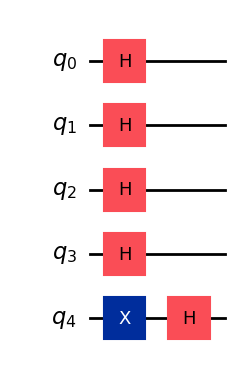

In [22]:
qr = QuantumRegister(n + 1, name="q")
cr = ClassicalRegister(n, name="c")

circuit1 = QuantumCircuit(qr)
circuit1.x(n)
circuit1.h(range(n + 1))
circuit1.draw("mpl")



Función generada:
f(0000) = 1
f(0001) = 1
f(0010) = 1
f(0011) = 1
f(0100) = 0
f(0101) = 1
f(0110) = 0
f(0111) = 1
f(1000) = 1
f(1001) = 1
f(1010) = 0
f(1011) = 1
f(1100) = 0
f(1101) = 1
f(1110) = 0
f(1111) = 0


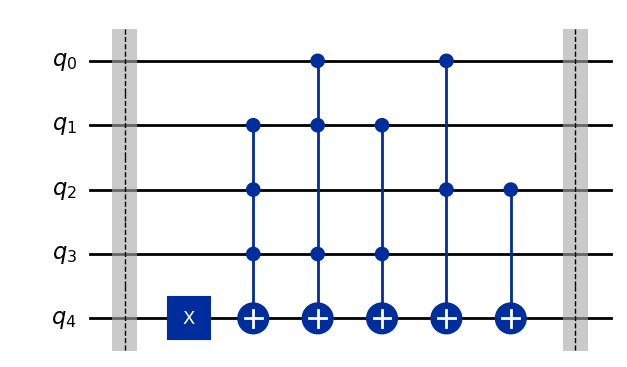

In [23]:
def balanced_random_binary(N):
    if N % 2 != 0:
        raise ValueError("N must be even to have equal number of 1s and 0s.")
    
    half = N // 2
    bits = [1] * half + [0] * half
    random.shuffle(bits)
    
    binary_string = ''.join(map(str, bits))
    return int(binary_string, 2)

circuit2 = QuantumCircuit(qr)
circuit2.barrier()
circuit2.draw("mpl")

if tipo == 0:
    if random.randint(0, 1):
        circuit2.x(n)
else:
    bits = 1<<n
    rep = balanced_random_binary(bits) if tipo == 1 else random.randint(0, (1<<bits) - 1)
    #rep = 0b11110000

    print("Función generada:")
    for i in range(bits):
        print(f"f({bin(i)[2:].zfill(n)}) = {1 if rep & (1<<i) else 0}")

    temp = QuantumCircuit(qr)

    start = rep & 1
    if start:
        temp.x(n)
    rep >>= 1

    maskList = []
    for i in range(1, bits):
        b = start
        for mask in reversed(maskList):
            b ^= ((i&mask) == mask)
        if b != rep&1:
            maskList.append(i)
        rep >>=1
    
    for mask in reversed(maskList):
        applied = [i for i in range(mask.bit_length()) if mask & (1 << i)] + [n]
        temp.append(MCXGate(len(applied) - 1), applied)

    circuit2.compose(temp, qubits=range(n + 1), inplace=True)

circuit2.barrier()
display(circuit2.draw("mpl"))

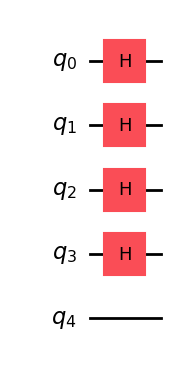

In [24]:
circuit3 = QuantumCircuit(qr)
circuit3.h(range(n))
circuit3.draw("mpl")

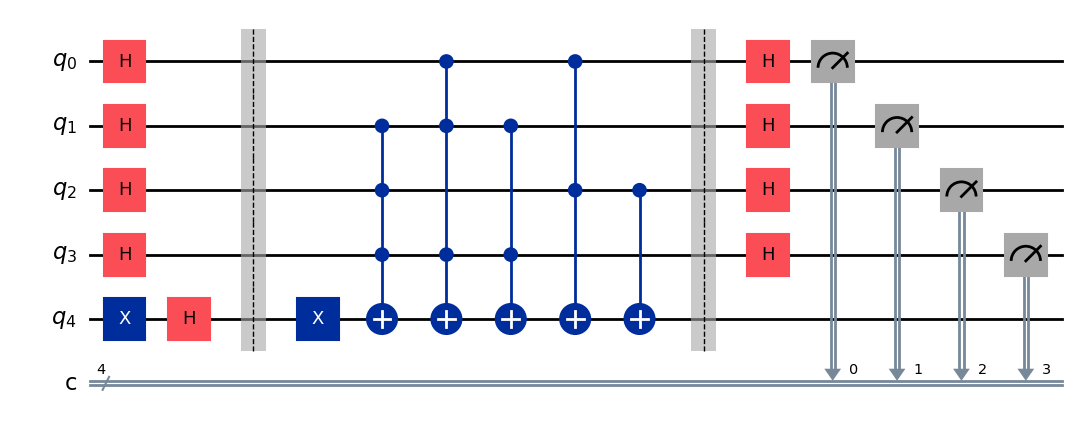

In [25]:
circuit = QuantumCircuit(qr, cr)
circuit.compose(circuit1, inplace=True)
circuit.compose(circuit2, inplace=True)
circuit.compose(circuit3, inplace=True)
circuit.measure(range(n), range(n))
circuit.draw("mpl")

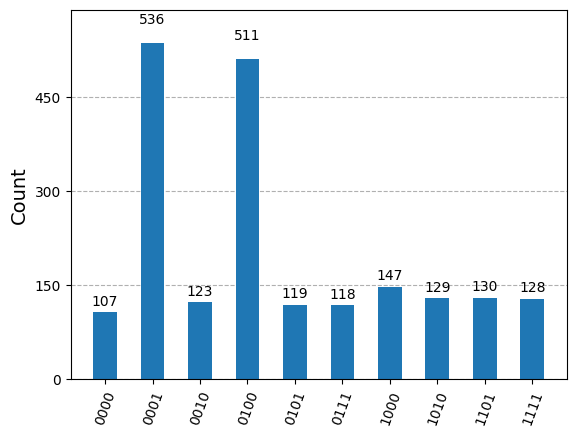

In [26]:
backend = Aer.get_backend('statevector_simulator')
compiled = transpile(circuit, backend)
counts = backend.run(compiled, shots=2048).result().get_counts()
display(plot_histogram(counts))

In [35]:
import sys

circOp = Operator.from_circuit(circuit2)
np.set_printoptions(threshold=sys.maxsize)
print(np.array(circOp, dtype=int))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

c:\Users\Wilberth David\AppData\Local\Programs\Python\Python312\Lib\site-packages\qiskit\quantum_info\operators\operator.py:126: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.array(self.data, dtype=dtype, copy=copy)


In [28]:
output = counts.get('0'*n, 0)
if output == 2048:
    print("Es una función constante")
elif output == 0:
    print("Es una función balanceada")
else:
    print("No es una función constante ni balanceada")

No es una función constante ni balanceada
